<a href="https://colab.research.google.com/github/albertorm/Data_Analytics_Coursework/blob/master/1_Plotting_Housing_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# London house price prediction by using HM Land Registry: Price Paid Data . 


Price Paid Data includes information on all property sales in England and Wales that are sold for full market value and are registered at HM Land Registry.

File include standard and additional price paid data transactions received at HM Land Registry from 1 January 1995 to the most current monthly data.

Accuracy of the data
Price paid information is not personal, but property-related information. All commercial transactions, sales that have not been lodged with HM Land Registry or sales that were not for full market value are excluded.

Columns in data

![attributes_table.png](attachment:attributes_table.png)

Total number of instances : 24020161

In [0]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import google
google.colab.drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will star to work with a sample of the data.
    

In [0]:
#################################################
#######Data exploration and pre processing ######
#################################################

#this was ran initially to get the complete data set in memory
df = pd.read_csv('pp-complete.csv', names=['uniqueId','price','dateOfTransfer',
     'postCode','propertyType','oldNew','duration','PAON','SAON','street',
     'locality','townCity','district','county','ppdCategoryType','recordStatus']
     ,dtype={'price': object},error_bad_lines=False)

#Filtering by those intances in where the property is located in London.
#After a review and under advice that prediction exercise should be done with a
#less amount of data. 
#It was decided that the prediction will be done by using data that corresponds 
#only to London and from the resulting subset , the boroughs with the major 
#amount of data will be picked for analysis.

#After a review and under advice that prediction exercise should be done with a 
#less amount of data. It was decided that the prediction will be done by using 
#data that corresponds only to London and from the resulting subset , the 
#boroughs with the major amount of data will be picked for analysis.

v_county='GREATER LONDON'
df_london = df[(df.county==v_county)]
#save new file
df_london.to_csv('london_house_prices.csv')

In [0]:
#Filtered records related to Greater London county, got 3154384 rows.


In [0]:
#After Feb 14 was agreed that representative boroughs will be: WESTMINSTER, 
#LAMBETH and CROYDON
#we filtered by those districts and got a new file londonBorougs.csv
#Opening generated file of county='GREATER LONDON'

df_london=pd.read_csv('london_house_prices.csv', 
                      names=['uniqueId','price','dateOfTransfer','postCode',
                             'propertyType','oldNew','duration','PAON','SAON',
                             'street','locality','townCity','district','county',
                             'ppdCategoryType','recordStatus'],
                      dtype={'price': object},error_bad_lines=False)

df_london['district'].value_counts()
representativeBoroughs=['LAMBETH','CROYDON','CITY OF WESTMINSTER']

In [0]:
#Preliminar subset of dataset containing only needed boroughs
londonBoroughs = 
df_london[(df_london['district'].str.upper().isin(representativeBoroughs))]

In [0]:
#Check for nulls
for column in londonBoroughs:   
    empty=pd.isnull(londonBoroughs[column]).value_counts()
    for idx in empty.index:        
        if idx:          
            print('Column: ',column, 'has', empty[idx],' nulls')

In [0]:
#Check now the percentage od these nulls. 
#Results show that we have a consistent data.
londonBoroughs.isnull().mean().sort_values(ascending=False)*100

In [0]:
# The columns selected for further usage were : Price, Date of Transfer,
# Property TypeExplanation, Old/New, Duration, District
# Remove not needed columns
londonBoroughs=londonBoroughs.drop(['uniqueId','postCode','PAON','SAON','street'
                                   ,'ppdCategoryType','recordStatus','locality']
                                   ,axis=1)

In [0]:
#Subset to remove property type "Others"
londonBoroughsWO_Others=londonBoroughs[(londonBoroughs['propertyType']!='O')]
londonBoroughsWO_Others.to_csv('londonBoroughsWO_Others.csv',header=True)
len(londonBoroughsWO_Others)

In [0]:
#Subset to remove outliers from subset that excluded "Others"

londonWoOtherWoOutliers =londonBoroughsWO_Others[(londonBoroughsWO_Others \
               ['price']>=20000) & (londonBoroughsWO_Others['price']<=30000000)]
londonBoroughsWO_Others.to_csv('londonWoOtherWoOutliers.csv',header=True)
len(londonWoOtherWoOutliers)

In [0]:
#Transform the price from house price dataset to real price

#Load of CPIH file to memory (Consumer price index for housing)

cpih = pd.read_csv("/content/gdrive/My Drive/DA_Coursework/4. \
Inflation (CPIH)/CPIH INDEX 1988_2019.csv")
cpih = cpih.rename(columns={'Title': 'Date', 'CPIH INDEX 00: ALL ITEMS \
2015=100': 'Value'})
cpih.drop(cpih.index[:7], inplace=True)
cpih.drop(cpih.index[31:], inplace=True)
cpih.Date = cpih.Date.astype(int)

#Load house price  dataset

s_boroughs = 
pd.read_csv("/content/gdrive/My Drive/DA_Coursework/3. Data/boroughs.csv")

s_boroughs['dateOfTransfer'] = pd.to_datetime(s_boroughs['dateOfTransfer'])

s_boroughs['year'] = 
pd.to_datetime(s_boroughs['dateOfTransfer']).dt.to_period('Y')

s_boroughs.year = s_boroughs.year.astype(str)

s_boroughs.year = s_boroughs.year.astype(int)

#Merge datasets 

s_boroughs = pd.merge(s_boroughs,cpih, left_on='year', right_on='Date')
s_boroughs['rprice'] = s_boroughs.Price/((s_boroughs.Value.astype(float))/66.6)

#Save into new subset.

s_boroughs.price = s_boroughs.rprice
s_boroughs = s_boroughs.drop(labels='rprice', axis=1)
s_boroughs.to_csv("/content/gdrive/My Drive/DA_Coursework/3. \
Data/londonBoroughs_realprice.csv")

In [0]:

#Once the files are saved we read them again to have them 
#in memory for further processing.

londonBoroughs=pd.read_csv('/content/drive/My Drive/DA_Coursework/3. \
Data/londonBoroughs.csv',index_col=0)
londonBoroughsRealPrice=pd.read_csv('/content/drive/My Drive/DA_Coursework/3. \
Data/londonBoroughs_realprice.csv',index_col=0)
londonBoroughsWO=pd.read_csv('/content/drive/My Drive/DA_Coursework/3. Data/lo\
ndonBoroughsWO_Others.csv',index_col=0)


In [0]:
#To identify outliers, we might use function zscore, which calculates , 
#for each price value , the number of sd that a value is far from the mean.
#This is not final and visu
#Whole set of all boroughs
prices=londonBoroughs['price'] 
print("\nDescription for whole set of selected boroughs: \n\n", \
      londonBoroughs.describe(),"\n")
z = stats.zscore(prices)
#using as example when Z is greater or equal to 20
outlier=np.where(z >= 20)
print(z,"\n")
print(outlier)
print(len(outlier[0]))
print("\nMin Z-score: ", min(z))
print("Max Z-score: ", max(z))


In [0]:
#Obtain stats for all the subsets
descriptions=pd.concat([londonBoroughs.describe(),londonBoroughsCOW.describe(),
                      londonBoroughsLAM.describe(),londonBoroughsCRO.describe(),
                      pricesWO_Others.describe(),pricesCOWWO_Others.describe(),
                      pricesLAMWO_Others.describe(),
                      pricesCROWO_Others.describe()],1)
descriptions.columns=["All Boroughs","Westminster","Lambeth","Croydon",
                      "All WO Others","Westminster WO Others",
                      "Lambeth WO Others","Croydon WO Others"]
descriptions

In [0]:
len(londonBoroughs.index)

377829

In [0]:
len(londonBoroughsRealPrice)

377829

In [0]:
londonBoroughs['district'].value_counts()

CROYDON                146442
LAMBETH                118519
CITY OF WESTMINSTER    112868
Name: district, dtype: int64

In [0]:
#We split data then by borough to obtain plots:

londonBoroughsCOW =
londonBoroughs[(londonBoroughs.district=='CITY OF WESTMINSTER')]

londonBoroughsLAM=londonBoroughs[(londonBoroughs.district=='LAMBETH')]
londonBoroughsCRO=londonBoroughs[(londonBoroughs.district=='CROYDON')]

# Plots.

Text(0, 0.5, 'Price')

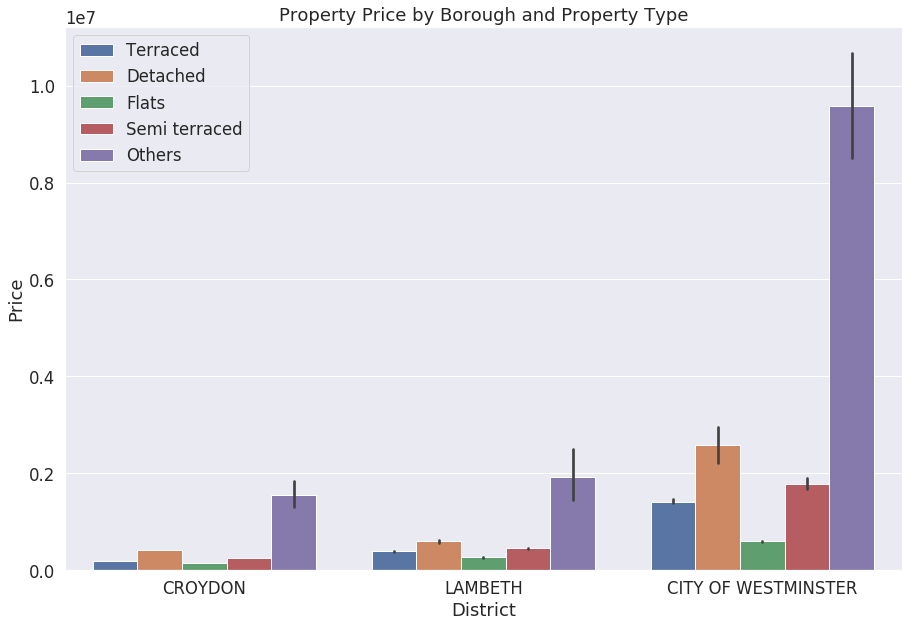

In [0]:
##################
#Plots
##################

#Property Price by Borough and Property Type

# Seaborn bigger than normal fonts
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 10))



ax=sns.barplot(x="district",y="price", data=londonBoroughs, hue='propertyType')
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Terraced", "Detached","Flats","Semi terraced", "Others"])

ax.set_title('Property Price by Borough and Property Type')
ax.set_xlabel('District')
ax.set_ylabel('Price')




Text(0, 0.5, 'Count')

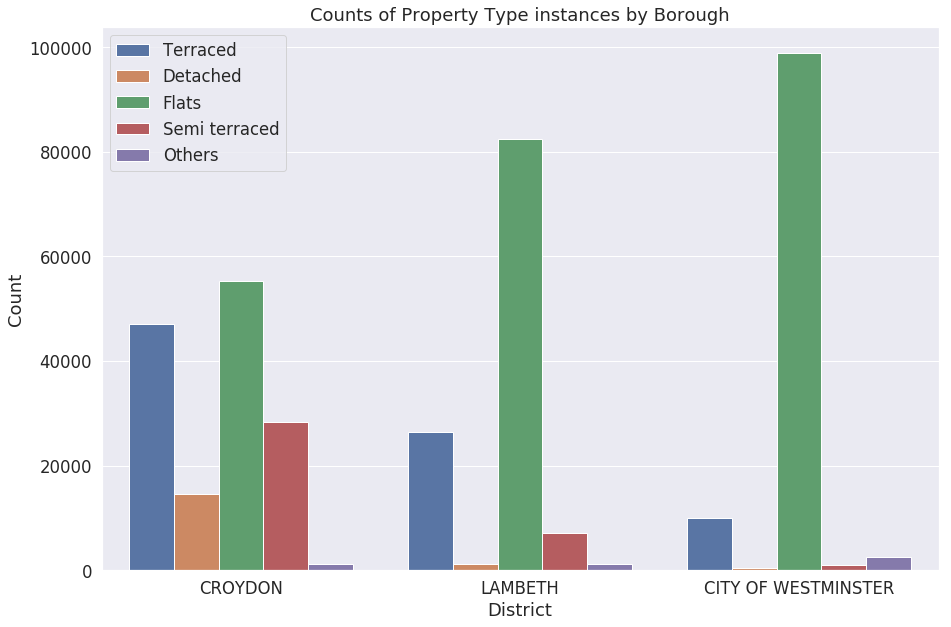

In [0]:
#Counts of Property Type instances by Borough

plt.figure(figsize=(15, 10))
ax = sns.countplot(x="district", data=londonBoroughs, hue='propertyType')
ax.set_title('Counts of Property Type instances by Borough')

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Terraced", "Detached","Flats","Semi terraced", "Others"])

ax.set_xlabel('District')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

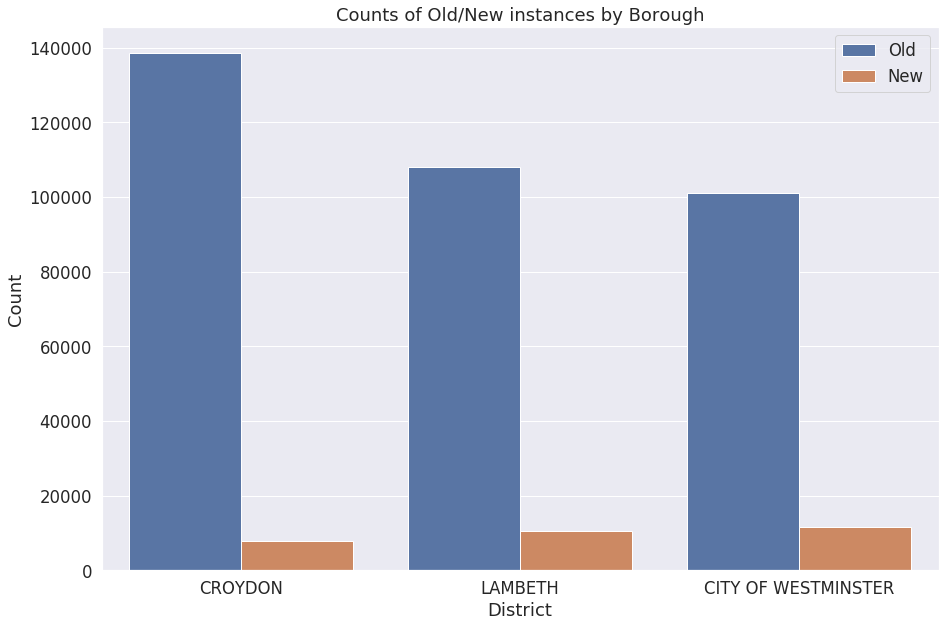

In [0]:
#Counts of Old/New instances by Borough

plt.figure(figsize=(15, 10))
ax = sns.countplot(x="district", data=londonBoroughs, hue='oldNew')
ax.set_title('Counts of Old/New instances by Borough')

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Old", "New"])

ax.set_xlabel('District')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

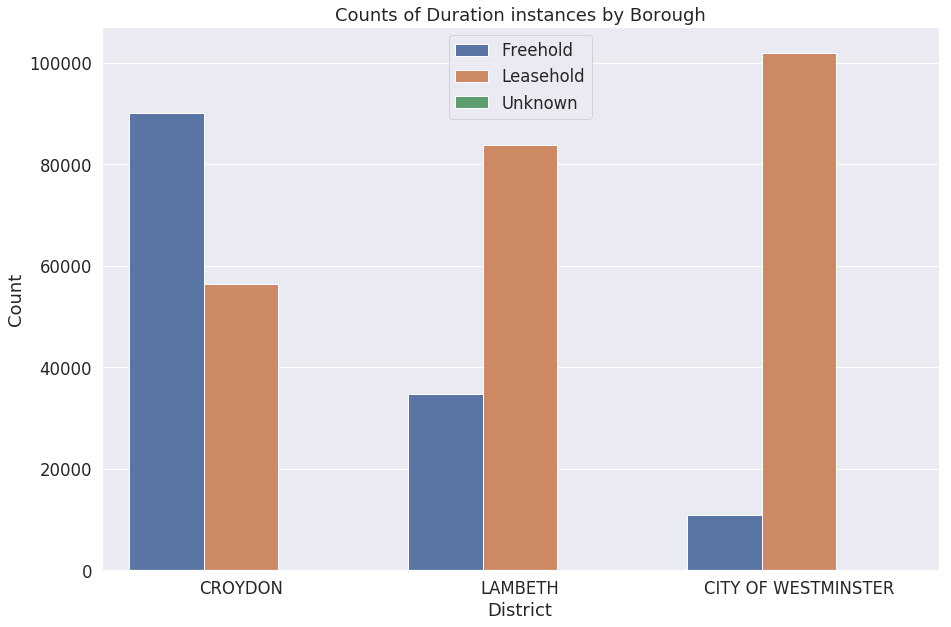

In [0]:
#Counts of Duration instances by Borough
plt.figure(figsize=(15, 10))
total=len(londonBoroughs.index)
ax = sns.countplot(x="district", data=londonBoroughs, hue='duration')
ax.set_title('Counts of Duration instances by Borough')
    
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Freehold", "Leasehold","Unknown"])

ax.set_xlabel('District')
ax.set_ylabel('Count')


In [0]:
#!pip install update seaborn==0.9.0

Text(0.5, 0, 'Price')

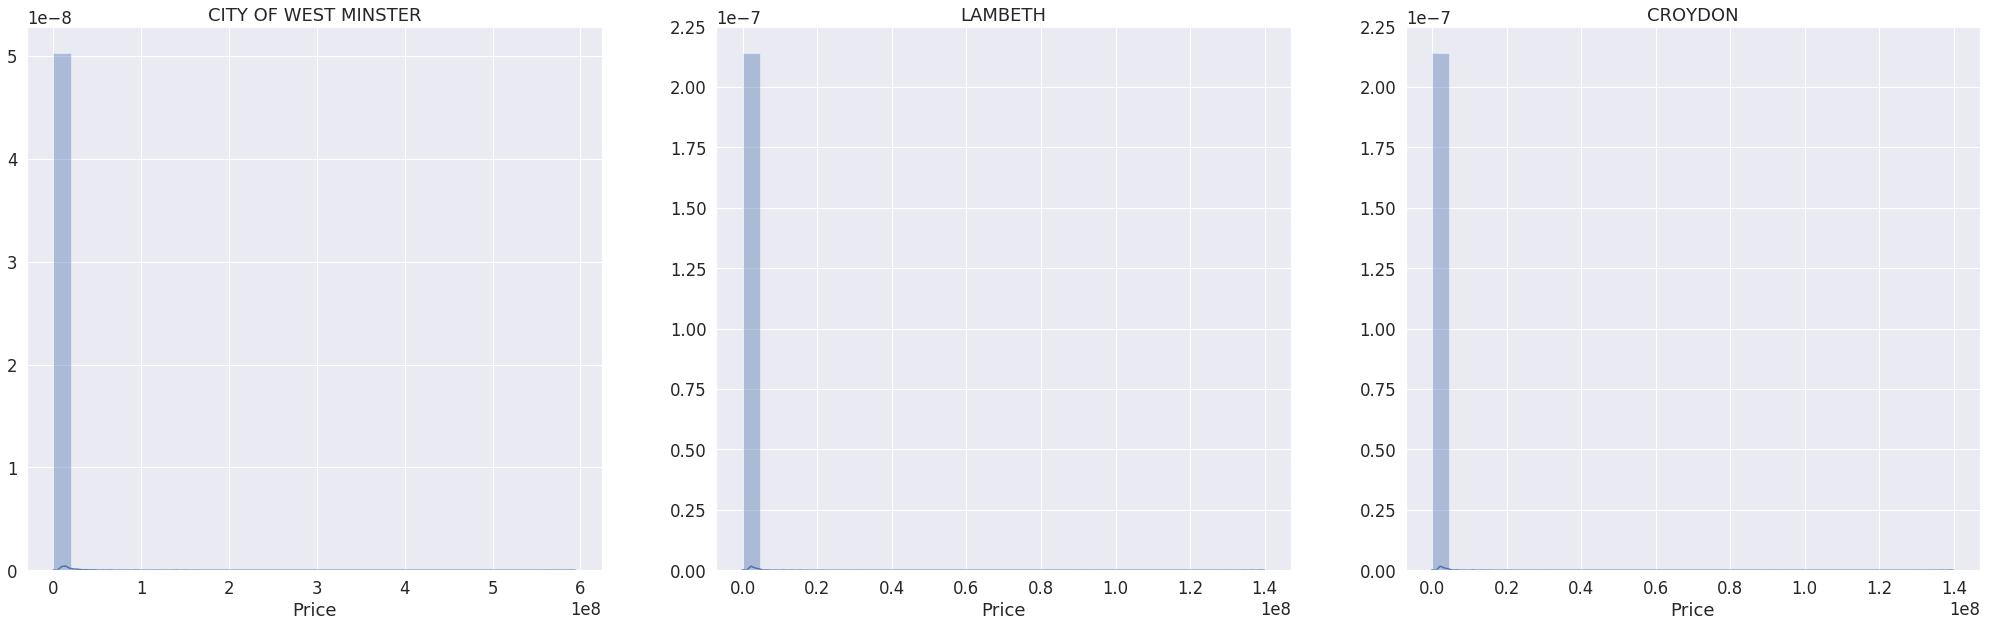

In [0]:
#Distributions with base data

#prices=londonBoroughs['price'] 
pricesCOW=londonBoroughsCOW['price'] 
pricesLAM=londonBoroughsLAM['price'] 
pricesCRO=londonBoroughsLAM['price'] 

fig = plt.figure(figsize=(35,10))

plt.subplot(1, 3, 1)
plt.title('CITY OF WEST MINSTER')
ax=sns.distplot(pricesCOW,bins=30)
ax.set_xlabel('Price')

plt.subplot(1, 3, 2)
plt.title('LAMBETH')
ax=sns.distplot(pricesLAM,bins=30)
ax.set_xlabel('Price')

plt.subplot(1, 3, 3)
plt.title('CROYDON')
ax=sns.distplot(pricesCRO,bins=30)
ax.set_xlabel('Price')


Text(0.5, 0, 'Price')

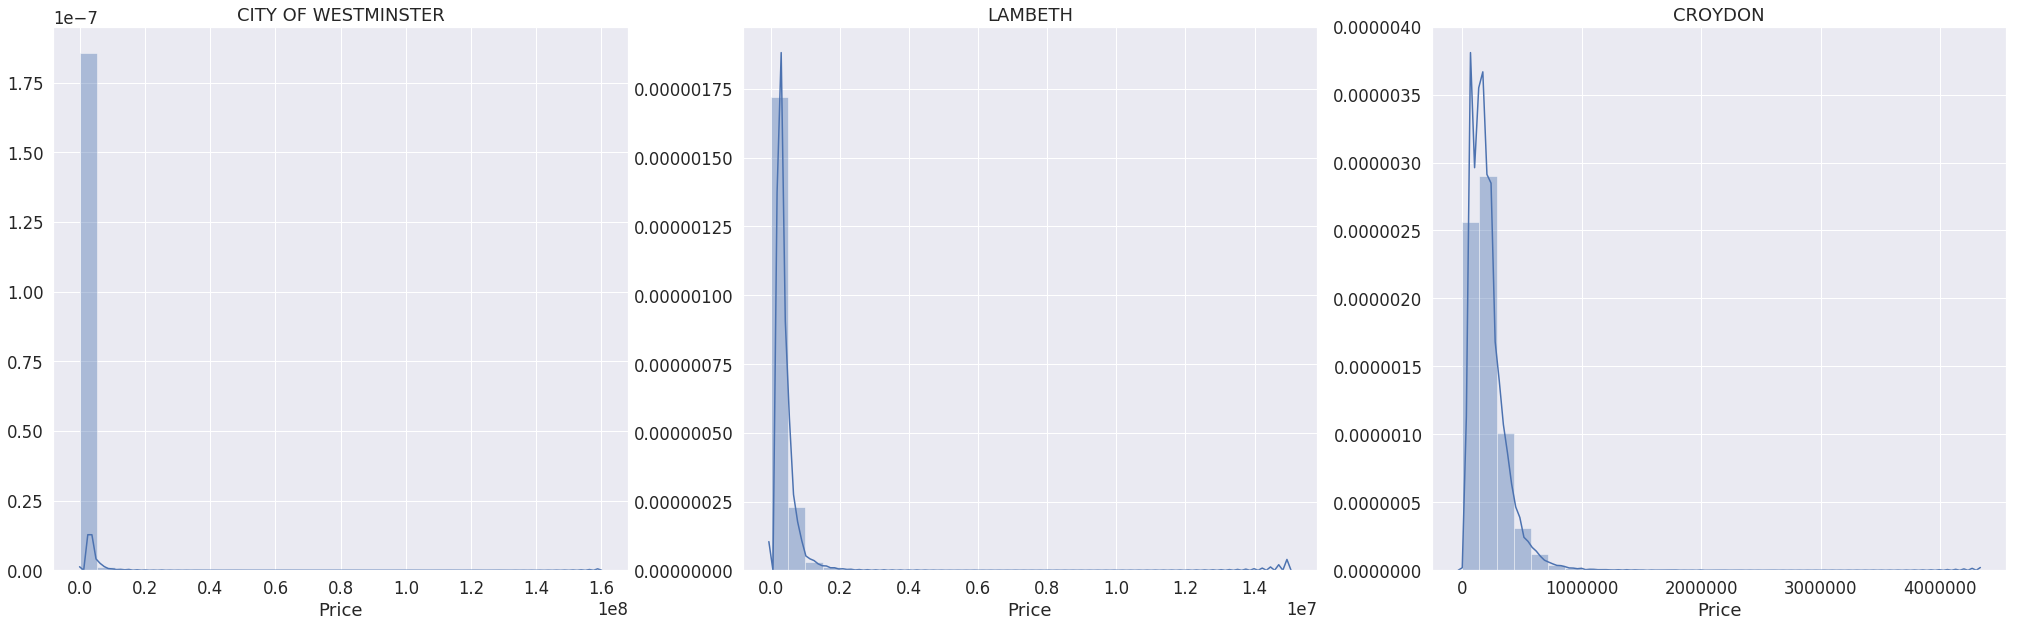

In [0]:
#Distributions removing Others property type

pricesWO_Others=londonBoroughs[(londonBoroughs['propertyType']!='O')]['price'] 

pricesCOWWO_Others = 
londonBoroughsCOW[(londonBoroughsCOW['propertyType']!='O')]['price'] 
pricesLAMWO_Others = 
londonBoroughsLAM[(londonBoroughsLAM['propertyType']!='O')]['price'] 
pricesCROWO_Others = 
londonBoroughsCRO[(londonBoroughsCRO['propertyType']!='O')]['price'] 

fig = plt.figure(figsize=(35,10))


plt.subplot(1, 3, 1)
plt.title('CITY OF WESTMINSTER')
ax=sns.distplot(pricesCOWWO_Others,bins=30)
ax.set_xlabel('Price')

plt.subplot(1, 3, 2)
plt.title('LAMBETH')
ax=sns.distplot(pricesLAMWO_Others,bins=30)
ax.set_xlabel('Price')

plt.subplot(1, 3, 3)
plt.title('CROYDON')
ax=sns.distplot(pricesCROWO_Others,bins=30)
ax.set_xlabel('Price')

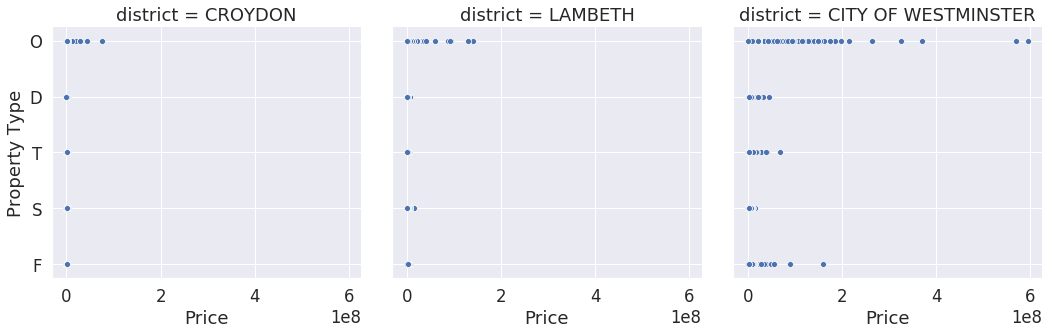

In [0]:
#Relation plot of price and property type by district

ax=(sns.relplot(x='price', y='propertyType' ,data=londonBoroughs, 
                col='district')).set_axis_labels("Price", "Property Type")


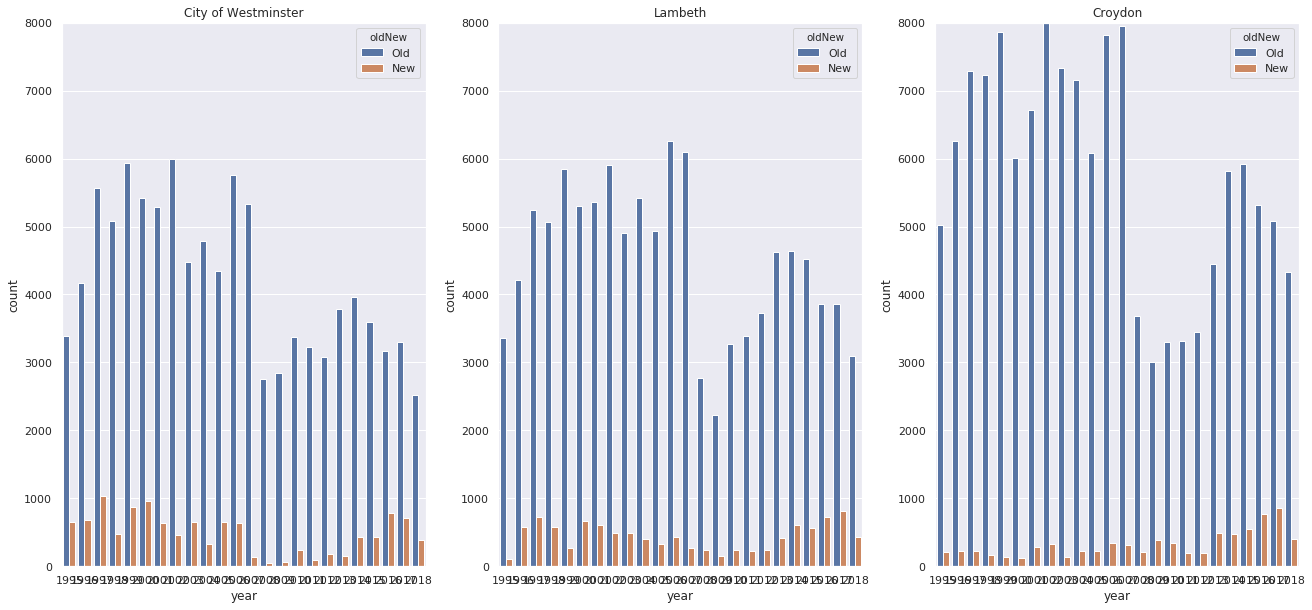

In [0]:
londonBoroughsDates=pd.read_csv('/content/drive/My Drive/DA_Coursework/3.\
Data/londonBoroughs.csv',index_col=0)
#londonBoroughsDates['dateOfTransfer'] = 
#pd.to_datetime(londonBoroughsDates['dateOfTransfer'], format='%Y-%m-%d')
londonBoroughsDates['dateOfTransfer'] = 
pd.to_datetime(londonBoroughsDates['dateOfTransfer'])

londonBoroughsDates['year']=
londonBoroughsDates['dateOfTransfer'].dt.year

londonBoroughsDates['oldNew'] = 
[w.replace('N', 'Old') for w in londonBoroughsDates['oldNew']]

londonBoroughsDates['oldNew'] = 
[w.replace('Y', 'New') for w in londonBoroughsDates['oldNew']]

fig = plt.figure(figsize=(30,10))


#plt.subplot(1, 4, 1)
#plt.title('All')
#sns.lineplot(x="year", y="price",
#             hue="oldNew", 
#             data=londonBoroughsDates)

plt.subplot(1, 4, 1)
plt.title('City of Westminster')
plt.axis([1994,2019,0,8000])
sns.countplot(x="year",
             hue="oldNew", 
             data=londonBoroughsDates\
              [(londonBoroughs.district=='CITY OF WESTMINSTER')])


plt.subplot(1, 4, 2)
plt.title('Lambeth')
plt.axis([1994,2019,0,8000])
sns.countplot(x="year", 
             hue="oldNew", 
             data=londonBoroughsDates[(londonBoroughs.district=='LAMBETH')])

plt.subplot(1, 4, 3)
plt.title('Croydon')
plt.axis([1994,2019,0,8000])
sns.countplot(x="year", 
             hue="oldNew", 
             data=londonBoroughsDates[(londonBoroughs.district=='CROYDON')])

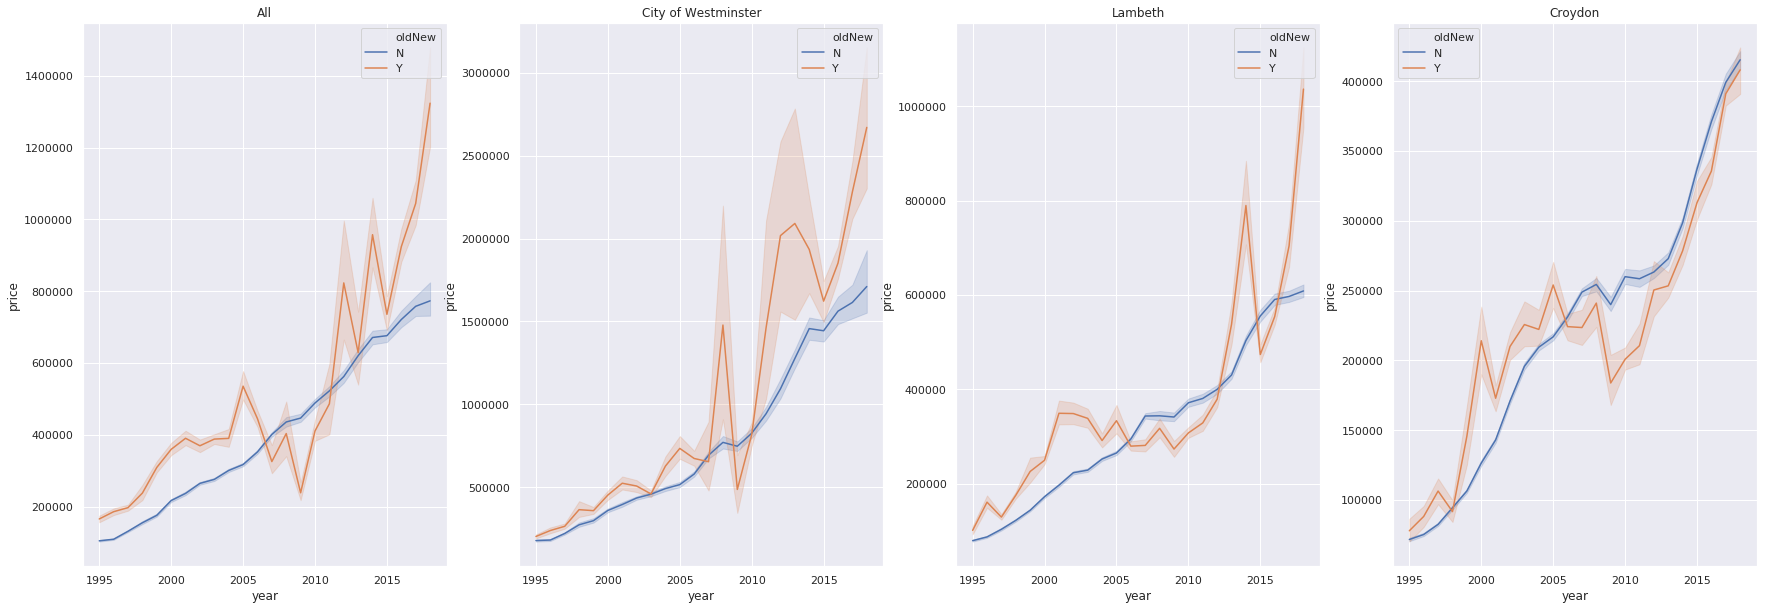

In [0]:
##Without others
londonBoroughsDatesWO=pd.read_csv('/content/drive/My Drive/DA_Coursework/3. \
Data/londonBoroughsWO_Others.csv',index_col=0)
#londonBoroughsDates['dateOfTransfer'] = 
#pd.to_datetime(londonBoroughsDates['dateOfTransfer'], format='%Y-%m-%d')
londonBoroughsDatesWO['dateOfTransfer'] = 
pd.to_datetime(londonBoroughsDatesWO['dateOfTransfer'])

londonBoroughsDatesWO['year']=londonBoroughsDatesWO['dateOfTransfer'].dt.year

fig = plt.figure(figsize=(30,10))


plt.subplot(1, 4, 1)
plt.title('All')
sns.lineplot(x="year", y="price",
             hue="oldNew", 
             data=londonBoroughsDatesWO)

plt.subplot(1, 4, 2)
plt.title('City of Westminster')
sns.lineplot(x="year", y="price",
             hue="oldNew", 
             data=londonBoroughsDatesWO[(londonBoroughsDatesWO.district=='CITY\
             OF WESTMINSTER')])

plt.subplot(1, 4, 3)
plt.title('Lambeth')
sns.lineplot(x="year", y="price",
             hue="oldNew", 
             data=londonBoroughsDatesWO[(londonBoroughsDatesWO.district==\
                                         'LAMBETH')])

plt.subplot(1, 4, 4)
plt.title('Croydon')
sns.lineplot(x="year", y="price",
             hue="oldNew", 
             data=londonBoroughsDatesWO[(londonBoroughsDatesWO.district==\
                                         'CROYDON')])

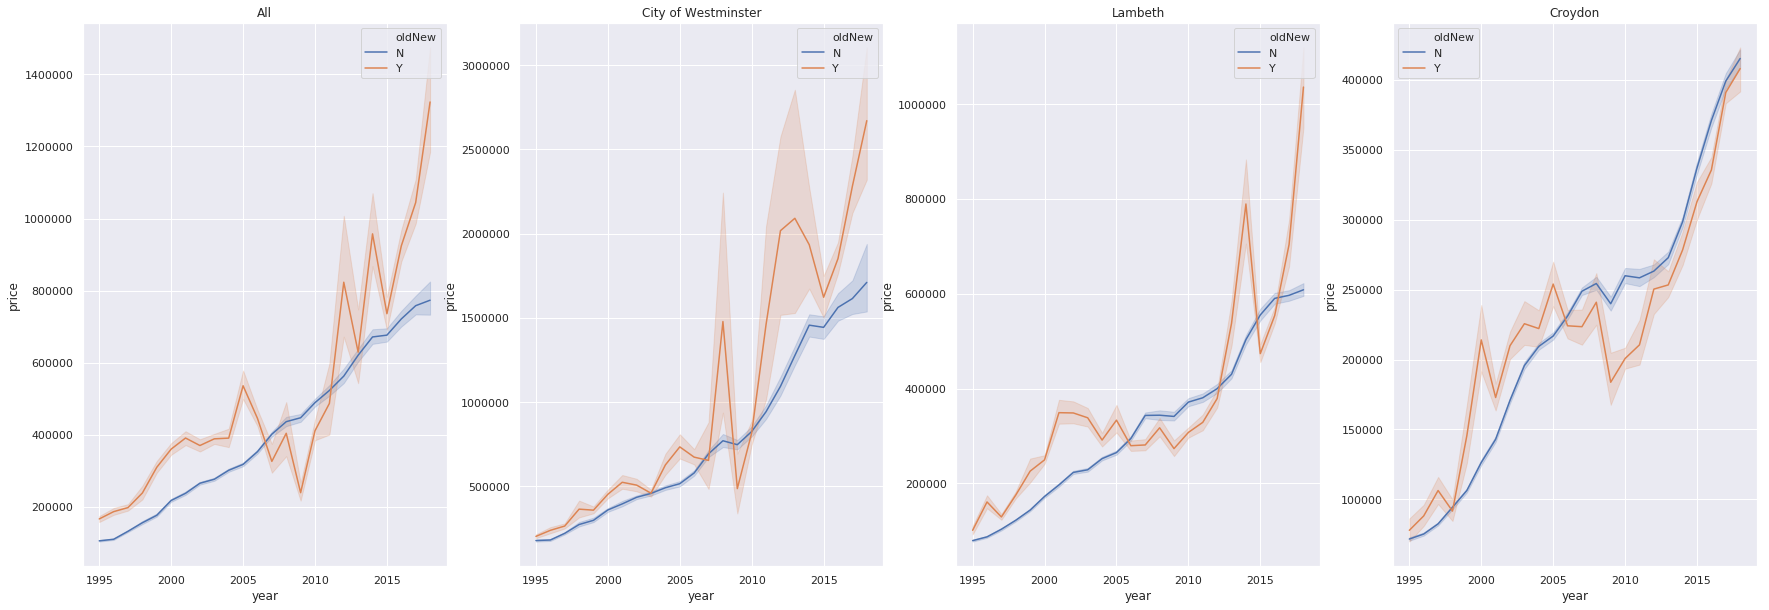

In [0]:
##Without others
londonBoroughsDatesWO = 
pd.read_csv('/content/drive/My Drive/DA_Coursework/3. \
Data/londonBoroughsWO_Others.csv',index_col=0)
#londonBoroughsDates['dateOfTransfer'] = 
#pd.to_datetime(londonBoroughsDates['dateOfTransfer'], format='%Y-%m-%d')

londonBoroughsDatesWO['dateOfTransfer'] = 
pd.to_datetime(londonBoroughsDatesWO['dateOfTransfer'])

londonBoroughsDatesWO['year']=londonBoroughsDatesWO['dateOfTransfer'].dt.year

fig = plt.figure(figsize=(30,10))


plt.subplot(1, 4, 1)
plt.title('All')
sns.lineplot(x="year", y="price",
             hue="oldNew", 
             data=londonBoroughsDatesWO)

plt.subplot(1, 4, 2)
plt.title('City of Westminster')
sns.lineplot(x="year", y="price",
             hue="oldNew", 
             data=londonBoroughsDatesWO[(londonBoroughsDatesWO.district=='CITY \
             OF WESTMINSTER')])

plt.subplot(1, 4, 3)
plt.title('Lambeth')
sns.lineplot(x="year", y="price",
             hue="oldNew", 
             data=londonBoroughsDatesWO[(londonBoroughsDatesWO.district==\
                                         'LAMBETH')])

plt.subplot(1, 4, 4)
plt.title('Croydon')
sns.lineplot(x="year", y="price",
             hue="oldNew", 
             data=londonBoroughsDatesWO[(londonBoroughsDatesWO.district==\
                                         'CROYDON')])

In [0]:
#################
#Correlations####
#################

#convert categorical values into dummie values.
londonBoroughs = pd.concat([londonBoroughs,
                            pd.get_dummies(londonBoroughs['propertyType'], 
                                           prefix='prop_type')],axis=1)
londonBoroughs = pd.concat([londonBoroughs,
                            pd.get_dummies(londonBoroughs['oldNew'], 
                                           prefix='oldNew')],axis=1)
londonBoroughs = pd.concat([londonBoroughs,
                            pd.get_dummies(londonBoroughs['duration'], 
                                           prefix='duration')],axis=1)
londonBoroughs = pd.concat([londonBoroughs,
                            pd.get_dummies(londonBoroughs['district'], 
                                           prefix='district')],axis=1)




In [0]:
#convert price to numeric
londonBoroughs['price'] = pd.to_numeric(londonBoroughs['price'])

londonBoroughs['dateOfTransfer'] = 
pd.to_datetime(londonBoroughs['dateOfTransfer'])

#londonBoroughs['year']=londonBoroughs['dateOfTransfer'].dt.year
#londonBoroughs['month']=londonBoroughs['dateOfTransfer'].dt.month
#londonBoroughs['day']=londonBoroughs['dateOfTransfer'].dt.day
londonBoroughs['dateOfTransfer'] = 
londonBoroughs['dateOfTransfer'].map(datetime.toordinal)



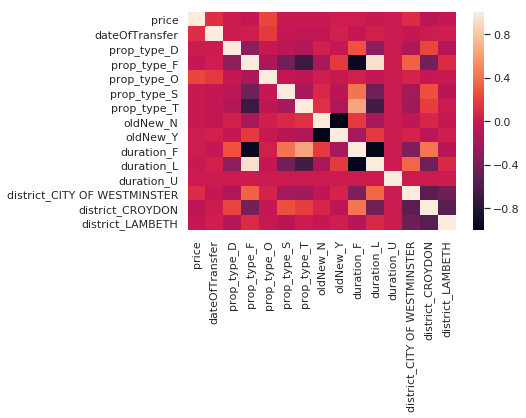

In [0]:
corr = londonBoroughs.corr()
sns.heatmap(corr, 
       xticklabels=corr.columns,
        yticklabels=corr.columns)


In [0]:
corr["price"].sort_values(ascending=False)


price                           1.000000
prop_type_O                     0.230106
dateOfTransfer                  0.119474
district_CITY OF WESTMINSTER    0.107609
duration_F                      0.013938
oldNew_Y                        0.010420
prop_type_D                     0.003539
duration_U                     -0.000450
prop_type_T                    -0.010226
oldNew_N                       -0.010420
duration_L                     -0.013933
prop_type_S                    -0.014730
district_LAMBETH               -0.032891
prop_type_F                    -0.036344
district_CROYDON               -0.069769
Name: price, dtype: float64

In [0]:
#Dates analysis wothout others.
londonBoroughsDatesWO = 
pd.concat([londonBoroughsDatesWO,
           pd.get_dummies(londonBoroughsDatesWO['propertyType']
                          , prefix='prop_type')],axis=1)

londonBoroughsDatesWO = 
pd.concat([londonBoroughsDatesWO,
           pd.get_dummies(londonBoroughsDatesWO['oldNew'], 
                          prefix='oldNew')],axis=1)

londonBoroughsDatesWO = 
pd.concat([londonBoroughsDatesWO,
           pd.get_dummies(londonBoroughsDatesWO['duration'], 
                          prefix='duration')],axis=1)
londonBoroughsDatesWO = 
pd.concat([londonBoroughsDatesWO,
           pd.get_dummies(londonBoroughsDatesWO['district'], 
                          prefix='district')],axis=1)


In [0]:
#LondonBoroughtswithoutOthers
#convert price to numeric
londonBoroughsDatesWO['price'] = 
pd.to_numeric(londonBoroughsDatesWO['price'])

londonBoroughsDatesWO['dateOfTransfer'] = 
pd.to_datetime(londonBoroughsDatesWO['dateOfTransfer'])

#londonBoroughsDatesWO['year']=londonBoroughsDatesWO['dateOfTransfer'].dt.year
#londonBoroughsDatesWO['month']=londonBoroughsDatesWO['dateOfTransfer'].dt.month
#londonBoroughsDatesWO['day']=londonBoroughsDatesWO['dateOfTransfer'].dt.day

londonBoroughsDatesWO['dateOfTransfer'] = 
londonBoroughsDatesWO['dateOfTransfer'].map(datetime.toordinal)

In [0]:
londonBoroughsDatesWO.head()

,price,dateOfTransfer,propertyType,oldNew,duration,townCity,district,county,year,prop_type_D,...,prop_type_S,prop_type_T,oldNew_N,oldNew_Y,duration_F,duration_L,duration_U,district_CITY OF WESTMINSTER,district_CROYDON,district_LAMBETH
36.0,54000,728619,T,N,F,CROYDON,CROYDON,GREATER LONDON,1995,0,...,0,1,1,0,1,0,0,0,1,0
59.0,59950,728395,T,N,F,LONDON,LAMBETH,GREATER LONDON,1995,0,...,0,1,1,0,1,0,0,0,0,1
176.0,93000,728453,D,N,F,COULSDON,CROYDON,GREATER LONDON,1995,1,...,0,0,1,0,1,0,0,0,1,0
212.0,110995,728606,F,Y,L,LONDON,LAMBETH,GREATER LONDON,1995,0,...,0,0,0,1,0,1,0,0,0,1
233.0,180000,728613,F,N,L,LONDON,CITY OF WESTMINSTER,GREATER LONDON,1995,0,...,0,0,1,0,0,1,0,1,0,0


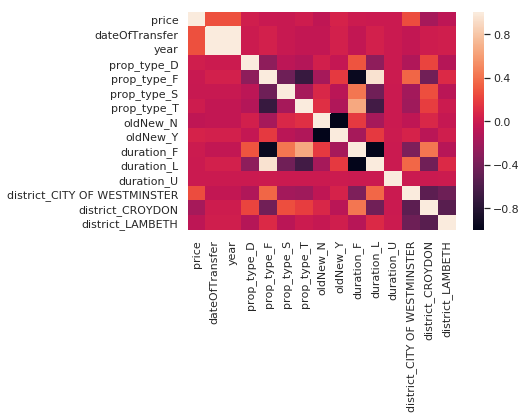

In [0]:
#londonBoroughsDatesWO=londonBoroughsDatesWO.drop(['year'],axis=1)


corr2 = londonBoroughsDatesWO.corr()
sns.heatmap(corr2, 
        xticklabels=corr2.columns,
        yticklabels=corr2.columns)



In [0]:
corr2["price"].sort_values(ascending=False)


price                           1.000000
dateOfTransfer                  0.271456
year                            0.271378
district_CITY OF WESTMINSTER    0.255068
oldNew_Y                        0.060489
prop_type_D                     0.030536
prop_type_T                     0.011867
duration_F                      0.000845
duration_L                     -0.000834
duration_U                     -0.001147
prop_type_F                    -0.010142
prop_type_S                    -0.021259
oldNew_N                       -0.060489
district_LAMBETH               -0.065385
district_CROYDON               -0.176493
Name: price, dtype: float64

In [0]:
londonBoroughsDatesWO =
londonBoroughsDatesWO.drop(['district_CITY OF WESTMINSTER',
                            'district_CROYDON','district_LAMBETH'],axis=1)

londonBoroughs_WO_COW=
londonBoroughsDatesWO[(londonBoroughsDatesWO.district=='CITY OF WESTMINSTER')]

londonBoroughs_WO_LAM=
londonBoroughsDatesWO[(londonBoroughsDatesWO.district=='LAMBETH')]

londonBoroughs_WO_CRO=
londonBoroughsDatesWO[(londonBoroughsDatesWO.district=='CROYDON')]

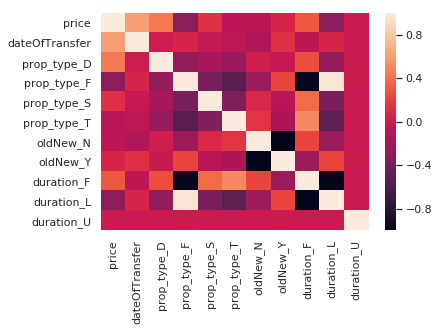

In [0]:
londonBoroughs_WO_CRO=londonBoroughs_WO_CRO.drop(['year'],axis=1)
corrCRO = londonBoroughs_WO_CRO.corr()
sns.heatmap(corrCRO, 
        xticklabels=corrCRO.columns,
        yticklabels=corrCRO.columns)


In [0]:
corrCRO["price"].sort_values(ascending=False)


price             1.000000
dateOfTransfer    0.606205
prop_type_D       0.445267
duration_F        0.300478
prop_type_S       0.127220
oldNew_Y          0.066579
duration_U       -0.001741
oldNew_N         -0.066579
prop_type_T      -0.083709
prop_type_F      -0.299262
duration_L       -0.300467
Name: price, dtype: float64

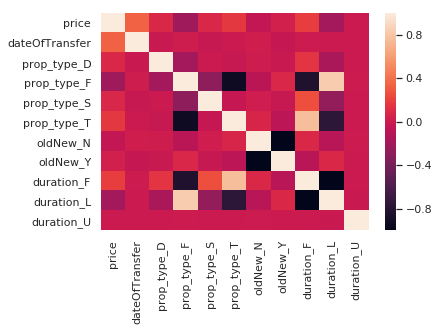

In [0]:
londonBoroughs_WO_COW=londonBoroughs_WO_COW.drop(['year'],axis=1)
corrCOW = londonBoroughs_WO_COW.corr()
sns.heatmap(corrCOW, 
        xticklabels=corrCOW.columns,
        yticklabels=corrCOW.columns)

In [0]:
corrCOW["price"].sort_values(ascending=False)


price             1.000000
dateOfTransfer    0.342243
duration_F        0.193150
prop_type_T       0.170682
prop_type_D       0.092746
prop_type_S       0.078876
oldNew_Y          0.045772
duration_U       -0.000699
oldNew_N         -0.045772
duration_L       -0.193134
prop_type_F      -0.205068
Name: price, dtype: float64

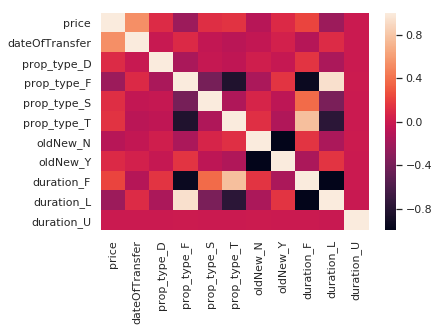

In [0]:
londonBoroughs_WO_LAM=londonBoroughs_WO_LAM.drop(['year'],axis=1)
corrLAM = londonBoroughs_WO_LAM.corr()
sns.heatmap(corrLAM, 
        xticklabels=corrLAM.columns,
        yticklabels=corrLAM.columns)

In [0]:
corrLAM["price"].sort_values(ascending=False)


price             1.000000
dateOfTransfer    0.535046
duration_F        0.221197
prop_type_T       0.145871
prop_type_S       0.122032
prop_type_D       0.101751
oldNew_Y          0.094038
duration_U       -0.003191
oldNew_N         -0.094038
prop_type_F      -0.220578
duration_L       -0.221148
Name: price, dtype: float64